In [72]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score

plt.rcParams['figure.figsize'] = (10, 6)
plt.style.use('seaborn')

In [73]:
df = pd.read_csv('../../data/un3_breast_cancer.csv').drop(['id', 'Unnamed: 32'], axis=1)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [74]:
df['diagnosis'].value_counts()

B    357
M    212
Name: diagnosis, dtype: int64

In [75]:
df['diagnosis'] = df['diagnosis'].replace(['B', 'M'], [1, -1])

## 2. Visualizando la distribución de los atributos

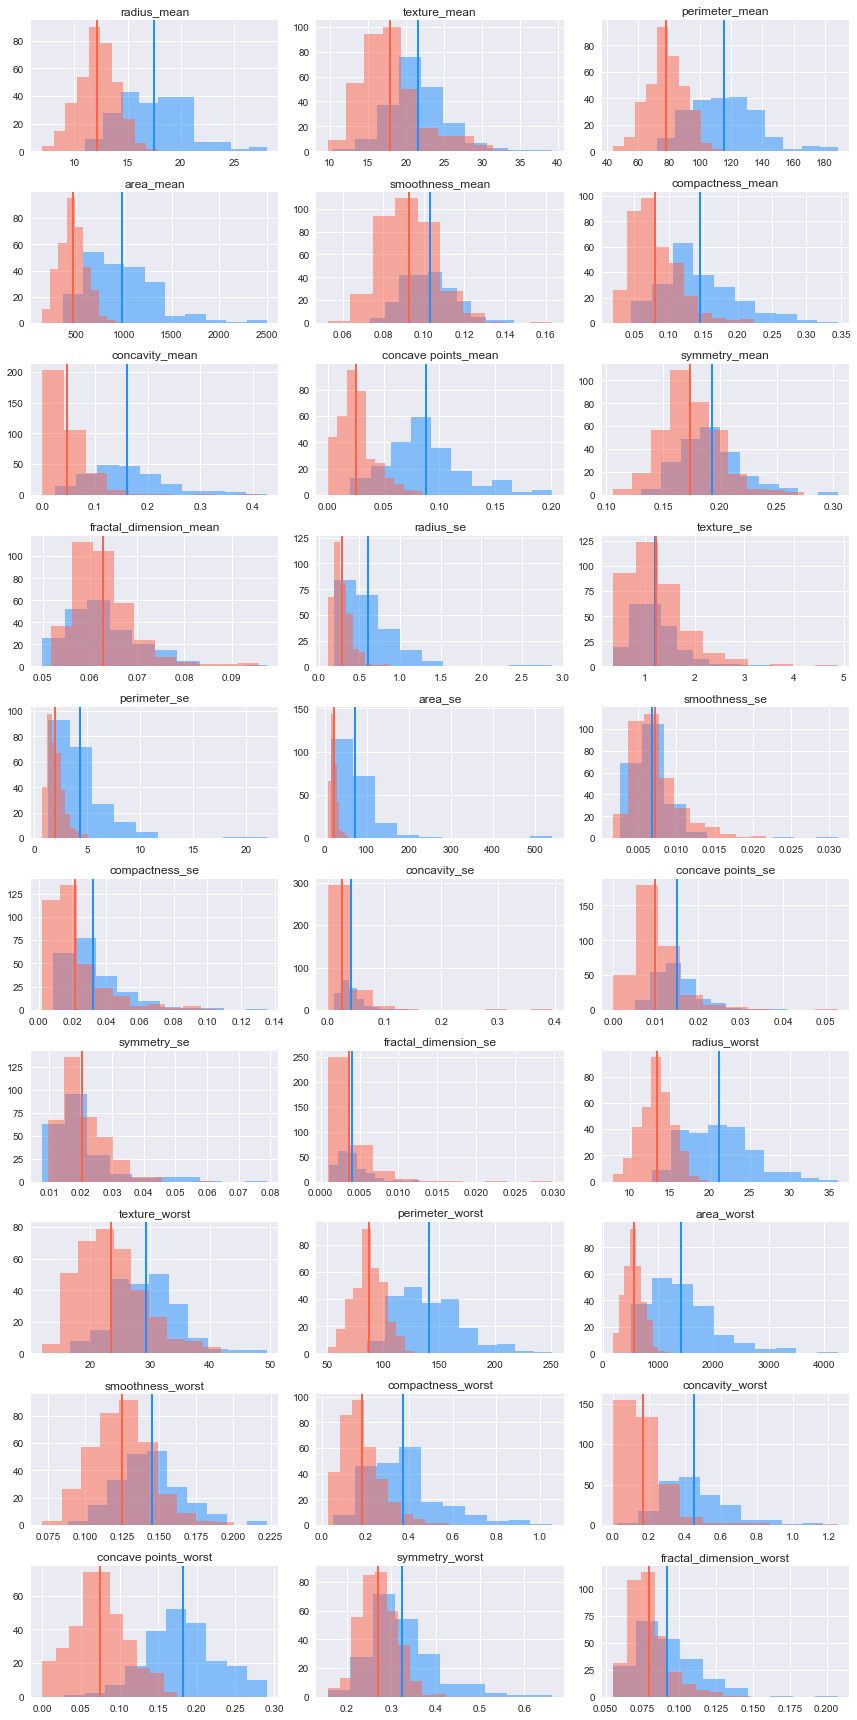

In [46]:
clean_columns = df.columns.drop('diagnosis')
rows = 10

cols = np.ceil(clean_columns.shape[0] / rows)
pal = ['dodgerblue', 'tomato']

plt.figure(figsize=(12, 24))
percentiles = []
preserve_overlap = []
varname = []
for index, colname in enumerate(clean_columns):
    plt.subplot(rows, cols, index + 1)
    for n,i in enumerate(df['diagnosis'].unique()):
        tmp_select = df[df['diagnosis'] == i][colname]
        plt.hist(tmp_select, alpha=.5, color=pal[n])
        plt.axvline(np.mean(tmp_select), lw=2, color=pal[n])
        plt.title(colname)
    varname.append(colname)
    plt.title("{}".format(colname))
plt.tight_layout()

## 3. Estimando el porcentaje de overlap en los atributos

In [47]:
def histogram_overlap(df, attribute, target, perc=100):
    empirical_lower_bound = np.floor(df[attribute].min())
    empirical_upper_bound = np.ceil(df[attribute].max())
    
    tmp_hist_holder = dict()
    
    for unique_value in np.unique(df[target]):
        tmp, _ = np.histogram( df[df[target] == unique_value][attribute],
                              bins=perc,
                              range=[empirical_lower_bound, empirical_upper_bound]
                             )
        
        tmp_hist_holder["h_"+str(unique_value)] = tmp
    get_minima = np.minimum(tmp_hist_holder["h_1"], 
                            tmp_hist_holder["h_-1"])
    intersection = np.true_divide(np.sum(get_minima),
                                  np.sum(tmp_hist_holder["h_-1"]))
    return intersection

In [48]:
clean_df = df.dropna()
preserve_overlap, varname = [], []

for i in clean_columns:
    preserve_overlap.append(
        histogram_overlap(df, i, 'diagnosis')
    )
    varname.append(i)
    
overlap_df = pd.DataFrame({'varname': varname,
                           'overlap_coef': list(map(lambda x: round(x,3),preserve_overlap))})
overlap_df = overlap_df.sort_values('overlap_coef', ascending=False)
overlap_df

,varname,overlap_coef
19,fractal_dimension_se,1.000
14,smoothness_se,0.995
9,fractal_dimension_mean,0.991
18,symmetry_se,0.958
11,texture_se,0.925
15,compactness_se,0.882
4,smoothness_mean,0.877
8,symmetry_mean,0.858
17,concave points_se,0.854
29,fractal_dimension_worst,0.830


## 4. Selección del modelo por GridSearchCV

In [9]:
X = StandardScaler().fit_transform(df.loc[:, 'radius_mean':'fractal_dimension_worst'])
X_train, X_test, y_train, y_test = train_test_split(X, df['diagnosis'])

In [76]:
params = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
          'gamma': [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}

get_params = GridSearchCV(SVC(kernel='rbf'), params, cv=10, return_train_score=True)
get_params.fit(X_train, y_train)

print(get_params.best_params_)
print(get_params.best_score_)

{'C': 100, 'gamma': 0.01}
0.953156146179402


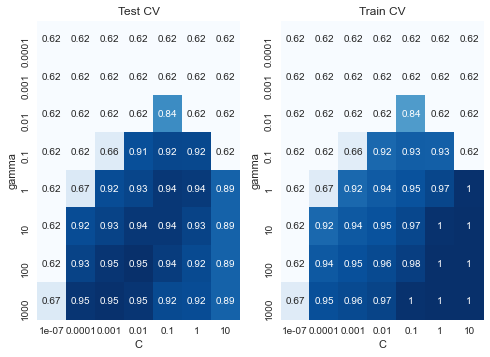

In [77]:
def report_heatmaps(cv_trained):
    param1 = tuple(cv_trained.param_grid.keys())[0]
    param2 = tuple(cv_trained.param_grid.keys())[1]
    
    plt.subplot(1, 2, 1)
    sns.heatmap(cv_trained.cv_results_['mean_test_score'].reshape(len(cv_trained.param_grid[param1]),
                                                                  len(cv_trained.param_grid[param2])),
                cmap='Blues', 
                annot=True,
                xticklabels=cv_trained.param_grid[param2],
                yticklabels=cv_trained.param_grid[param1],cbar=False)
    
    plt.ylabel(param2)
    plt.xlabel(param1)
    plt.title('Test CV')
    
    plt.subplot(1, 2, 2)
    sns.heatmap(cv_trained.cv_results_['mean_train_score'].reshape(len(cv_trained.param_grid[param1]),
                                                               len(cv_trained.param_grid[param2])),
                cmap='Blues', 
                annot=True,
                xticklabels=cv_trained.param_grid[param2],
                yticklabels=cv_trained.param_grid[param1],cbar=False)
    plt.ylabel(param2)
    plt.xlabel(param1)
    plt.title('Train CV')
    
    
report_heatmaps(get_params)

## 5. Validación del modelo en el Test set sample

In [78]:
best_svc = get_params.best_estimator_.fit(X_train, y_train)
print(classification_report(y_test, best_svc.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.96      0.92      0.94        51
           1       0.96      0.98      0.97        92

    accuracy                           0.96       143
   macro avg       0.96      0.95      0.95       143
weighted avg       0.96      0.96      0.96       143



In [87]:
low_overlap = list(overlap_df.query("overlap_coef < .45")['varname'].values)
depure_df = df.loc[:, low_overlap]

In [88]:
X = StandardScaler().fit_transform(depure_df.loc[:, low_overlap[0]:low_overlap[-1]])
X_train, X_test, y_train, y_test = train_test_split(X, df['diagnosis'])

params = {'C': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
          'gamma': [0.0000001, 0.0001, 0.001, 0.01, 0.1, 1, 10]}

get_params = GridSearchCV(SVC(kernel='rbf'), params, cv=10, return_train_score=True)
get_params.fit(X_train, y_train)
print(get_params.best_params_)
print(get_params.best_score_)

{'C': 10, 'gamma': 0.1}
0.9599667774086379


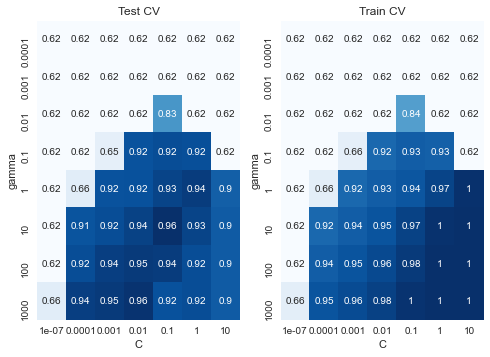

In [89]:
report_heatmaps(get_params)

In [90]:
best_svc = get_params.best_estimator_.fit(X_train, y_train)
print(classification_report(y_test, best_svc.predict(X_test)))

              precision    recall  f1-score   support

          -1       0.98      0.92      0.95        52
           1       0.96      0.99      0.97        91

    accuracy                           0.97       143
   macro avg       0.97      0.96      0.96       143
weighted avg       0.97      0.97      0.96       143



In [91]:
## PROBAR REGRESION LOGISTICA
## PROBAR NAIVE BAYES
## PROBAR LDA Y QDA

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis

In [92]:
X = StandardScaler().fit_transform(depure_df.loc[:, low_overlap[0]:low_overlap[-1]])
X_train, X_test, y_train, y_test = train_test_split(X, df['diagnosis'])

In [93]:
estimadores = {
    'LOGIT': LogisticRegression(),
    'NB': BernoulliNB(),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'SVM': SVC(kernel='rbf', C= 1000, gamma= 0.01)
}

In [94]:
for name, clf in estimadores.items():
    print(name)
    clf.fit(X_train, y_train)
    y_hat = clf.predict(X_test)
    print(classification_report(y_test, y_hat))
    print('-'*100)

LOGIT
              precision    recall  f1-score   support

          -1       0.93      0.98      0.96        55
           1       0.99      0.95      0.97        88

    accuracy                           0.97       143
   macro avg       0.96      0.97      0.96       143
weighted avg       0.97      0.97      0.97       143

----------------------------------------------------------------------------------------------------
NB
              precision    recall  f1-score   support

          -1       0.89      0.91      0.90        55
           1       0.94      0.93      0.94        88

    accuracy                           0.92       143
   macro avg       0.92      0.92      0.92       143
weighted avg       0.92      0.92      0.92       143

----------------------------------------------------------------------------------------------------
LDA
              precision    recall  f1-score   support

          -1       1.00      0.87      0.93        55
           1       0.9